In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [25]:
!pip install missingno


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
csv_path = os.path.join('..','datasets','raw','data.csv')
df = pd.read_csv(csv_path)
df.sample(10)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
4454,Ford,F-150 Heritage,2004,regular unleaded,231.0,8.0,AUTOMATIC,four wheel drive,4.0,NaN,Large,Extended Cab Pickup,17,13,5657,26460
1849,Volkswagen,Beetle Convertible,2015,premium unleaded (recommended),210.0,4.0,AUTOMATED_MANUAL,front wheel drive,2.0,Performance,Compact,Convertible,29,23,873,35975
2897,Lincoln,Continental,2001,regular unleaded,275.0,8.0,AUTOMATIC,front wheel drive,4.0,Luxury,Large,Sedan,23,15,61,39660
712,Mazda,6,2016,regular unleaded,184.0,4.0,MANUAL,front wheel drive,4.0,NaN,Midsize,Sedan,37,25,586,21495
5440,Volkswagen,Golf SportWagen,2017,regular unleaded,170.0,4.0,AUTOMATIC,front wheel drive,4.0,NaN,Compact,Wagon,34,25,873,27030
11657,Hyundai,XG350,2005,regular unleaded,194.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,24,16,1439,24899
3461,Dodge,Dakota,2009,regular unleaded,210.0,6.0,MANUAL,four wheel drive,4.0,Flex Fuel,Compact,Crew Cab Pickup,19,15,1851,28210
902,Saab,900,1997,regular unleaded,185.0,4.0,MANUAL,front wheel drive,4.0,"Hatchback,Luxury,Performance",Compact,4dr Hatchback,25,18,376,2000
9763,Chevrolet,Sonic,2015,regular unleaded,138.0,4.0,AUTOMATIC,front wheel drive,4.0,NaN,Compact,Sedan,37,27,1385,19680
8403,Toyota,RAV4,2017,regular unleaded,176.0,4.0,AUTOMATIC,front wheel drive,4.0,Crossover,Midsize,4dr SUV,30,23,2031,29985


In [3]:
len(df)

11914

In [4]:
df.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

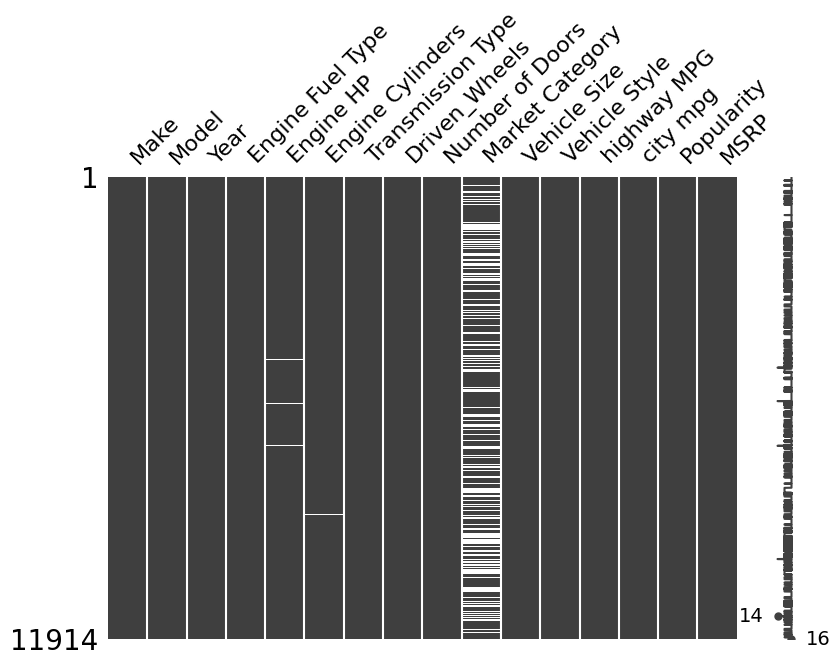

In [34]:
msno.matrix(df, figsize=(9,6))
plt.show()

In [6]:
# Valores pérdidos
cars.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [5]:
#my_variables = ['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']
cars = df.copy()

# Lowercase the column names and replace spaces with underscores
cars.columns = cars.columns.str.lower().str.replace(' ','_')
# Lista de la variables categóricas
categorical = list(cars.dtypes[cars.dtypes == 'object'].index)
# Lista de las variables numéricas
numerical = list(cars.dtypes[cars.dtypes != 'object'].index)


for feature in categorical:
    cars[feature] = cars[feature].str.lower().str.replace(' ', '_')
    
cars.sample(5)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
3623,dodge,durango,2016,premium_unleaded_(recommended),360.0,8.0,automatic,all_wheel_drive,4.0,"crossover,performance",large,4dr_suv,22,14,1851,44595
1960,chevrolet,beretta,1996,regular_unleaded,120.0,4.0,manual,front_wheel_drive,2.0,NaN,midsize,coupe,33,22,1385,2000
6871,lincoln,mkt,2015,premium_unleaded_(recommended),365.0,6.0,automatic,all_wheel_drive,4.0,"crossover,luxury,performance",large,wagon,23,16,61,45205
8058,dodge,ram_150,1992,regular_unleaded,230.0,8.0,manual,rear_wheel_drive,2.0,NaN,large,extended_cab_pickup,16,11,1851,2000
2816,dodge,colt,1993,regular_unleaded,92.0,4.0,manual,front_wheel_drive,4.0,NaN,compact,sedan,36,28,1851,2000


In [7]:
# Relleno valores pérdidos con 0
cars[['engine_hp','engine_cylinders']] = cars[['engine_hp','engine_cylinders']].fillna(value=0)

categorical.remove('market_category')

In [8]:
# Creación de una nueva variables objetivo

# Valor de la media de msrp
msrp_mean = cars['msrp'].mean()

# Precio por debajo de la media
cars['above_average'] = (cars['msrp'] <= msrp_mean).astype(int)

# Distribución
cars['above_average'].value_counts()

above_average
1    8645
0    3269
Name: count, dtype: int64

In [9]:
# Cantidad de valores únicos por variable(categórica)
cars[categorical].nunique()

make                  48
model                914
engine_fuel_type      10
transmission_type      5
driven_wheels          4
vehicle_size           3
vehicle_style         16
dtype: int64

In [10]:
df_train_full, df_test = train_test_split(cars, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)

y_train = df_train.msrp.values
y_val = df_val.msrp.values

del df_train['msrp']
del df_val['msrp']

In [11]:
# Lista los valores únicos de las variables categóricas
for feature in categorical:
    if df_train_full[feature].nunique() <= 16:
        print(feature)
        print(f"{df_train_full[feature].unique()} \n")
        

engine_fuel_type
['premium_unleaded_(required)' 'flex-fuel_(unleaded/e85)'
 'premium_unleaded_(recommended)' 'regular_unleaded' 'diesel'
 'flex-fuel_(premium_unleaded_required/e85)' 'electric'
 'flex-fuel_(premium_unleaded_recommended/e85)'
 'flex-fuel_(unleaded/natural_gas)' nan 'natural_gas'] 

transmission_type
['automatic' 'manual' 'automated_manual' 'direct_drive' 'unknown'] 

driven_wheels
['rear_wheel_drive' 'all_wheel_drive' 'front_wheel_drive'
 'four_wheel_drive'] 

vehicle_size
['compact' 'large' 'midsize'] 

vehicle_style
['coupe' 'extended_cab_pickup' 'convertible' '4dr_hatchback' '4dr_suv'
 'sedan' 'passenger_minivan' '2dr_suv' 'wagon' 'passenger_van'
 'crew_cab_pickup' 'regular_cab_pickup' 'convertible_suv' '2dr_hatchback'
 'cargo_minivan' 'cargo_van'] 



In [12]:
# Entradas con valor 'nan' en variable 'engine_fuel_type'
df_train_full[df_train_full.engine_fuel_type.isna()]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,above_average
11321,suzuki,verona,2004,NaN,155.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,25,17,481,17199,1
11322,suzuki,verona,2004,NaN,155.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,25,17,481,20199,1
11323,suzuki,verona,2004,NaN,155.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,25,17,481,18499,1


In [13]:
# Entradas con valor 'unknown' en variable 'trasnmission_type'
df_train_full[df_train_full.transmission_type == "unknown"]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,above_average
6158,gmc,jimmy,1999,regular_unleaded,190.0,6.0,unknown,rear_wheel_drive,2.0,NaN,compact,2dr_suv,19,14,549,2182,1
8053,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
6174,gmc,jimmy,2000,regular_unleaded,190.0,6.0,unknown,four_wheel_drive,2.0,NaN,compact,2dr_suv,18,14,549,2578,1
4691,pontiac,firebird,2000,regular_unleaded,305.0,8.0,unknown,rear_wheel_drive,2.0,"hatchback,performance",midsize,2dr_hatchback,23,15,210,6175,1
8048,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
8047,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
6160,gmc,jimmy,1999,regular_unleaded,190.0,6.0,unknown,four_wheel_drive,2.0,NaN,compact,2dr_suv,19,14,549,2317,1
8046,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
8051,dodge,ram_150,1991,regular_unleaded,125.0,6.0,unknown,rear_wheel_drive,2.0,NaN,large,regular_cab_pickup,17,12,1851,2000,1
6368,chrysler,le_baron,1993,regular_unleaded,100.0,4.0,unknown,front_wheel_drive,2.0,NaN,compact,convertible,24,18,1013,2000,1


## Feature Engineering

In [14]:
def map_engine_fuel_type(fuel_type):
    for key, values in fuel_types.items():
        if fuel_type in values:
            return key
    return None  # Si no se encuentra ninguna coincidencia, puedes manejarla como desees

fuel_types = {
    'premium': ['premium_unleaded_(required)', 'premium_unleaded_(recommended)'],
    'regular': ['regular_unleaded'],
    'diesel': ['diesel'],
    'flex': [
        'flex-fuel_(unleaded/e85)',
        'flex-fuel_(premium_unleaded_required/e85)',
        'flex-fuel_(premium_unleaded_recommended/e85)',
        'flex-fuel_(unleaded/natural_gas)'
    ],
    'electric': ['electric'],
    'gas': ['natural_gas'],
    'other': ['nan']
}

# Utiliza la función map_engine_fuel_type para mapear los valores en 'engine_fuel_type'
df_train_full['engine_fuel_type'] = df_train_full['engine_fuel_type'].map(map_engine_fuel_type)


In [15]:
# Relleno valores pérdidos con 0
cars[['engine_hp','engine_cylinders']] = cars[['engine_hp','engine_cylinders']].fillna(value=0)

# Millas por galón promedio
df_train_full['mpg_avg'] = df_train_full['highway_mpg'] + df_train_full['city_mpg'] / 2

# Reemplaza 'unknown' por 'manual' en variable 'transmission_type'
df_train_full['transmission_type'] = df_train_full.transmission_type.str.replace('unknown', 'manual')

categorical_features = ['make', 'model', 'transmission_type',]

numerical_features = ['year', 'engine_hp', 'engine_cylinders']


## Feature Importance

### Mutual Information

In [16]:
from sklearn.metrics import mutual_info_score

def calculate_mi(series):
    """
    Calcula el puntaje de información mutua de las variables categóricas 
    con respecto a 'above_average'
    """
    return mutual_info_score(series, df_train_full.above_average)


df_train_full.dropna(inplace=True)
mi_scores = df_train_full[categorical].apply(calculate_mi)
mi_scores.sort_values(ascending=False)

model                0.513520
make                 0.253498
driven_wheels        0.108291
vehicle_style        0.107374
engine_fuel_type     0.096729
vehicle_size         0.039284
transmission_type    0.010437
dtype: float64

### Risk Ratio

In [17]:
global_mean = df_train_full.above_average.mean()
global_mean

0.628804180756225

In [18]:
manual_transmission = df_train_full[df_train_full.transmission_type == 'manual'].above_average.mean()
automatic_transmission = df_train_full[df_train_full.transmission_type == 'automatic'].above_average.mean()
manual_transmission, automatic_transmission

(0.75254730713246, 0.6046157195732637)

### Correlation Coefficient

In [19]:
compact_size = df_train_full[df_train_full.vehicle_size == 'compact'].above_average.mean()
mid_size = df_train_full[df_train_full.vehicle_size == 'midsize'].above_average.mean()
large_size = df_train_full[df_train_full.vehicle_size == 'large'].above_average.mean()
compact_size

0.7739059967585089

In [20]:
df_train_full[numerical].corrwith(df_train_full.above_average).sort_values(ascending=True)

engine_hp          -0.633918
engine_cylinders   -0.468945
msrp               -0.447016
year               -0.252045
popularity          0.003677
number_of_doors     0.089007
highway_mpg         0.176721
city_mpg            0.193675
dtype: float64

In [21]:
df_train_full[numerical].corrwith(df_train_full.msrp).sort_values(ascending=True)

highway_mpg        -0.208097
city_mpg           -0.195316
number_of_doors    -0.182817
popularity         -0.052330
year                0.130847
engine_cylinders    0.570702
engine_hp           0.641806
msrp                1.000000
dtype: float64

## Preprocessing

In [22]:
# Importa la clase Dict vectorizer para convertir datos categóricos en formato dicciionario a formato numérico
dv = DictVectorizer(sparse=False)

# Convierte el conjunto de entrenamiento en un formato de lista de diccionarios
train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# Crea un modelo de regresión logística
#model = LogisticRegression(solver='liblinear')

# Entrena el modelo de regresión logística
#model.fit(X_train, y_train)

#val_dict = df_val.to_dict(orient='records')
#X_val = dv.transform(val_dict)

#y_pred = model.predict_proba(X_val)[:, 1]
#y_pred

X_train

array([[6.000e+00, 3.480e+02, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        2.013e+03],
       [6.000e+00, 2.750e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        2.017e+03],
       [4.000e+00, 1.400e+02, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        1.992e+03],
       ...,
       [4.000e+00, 1.300e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        2.017e+03],
       [5.000e+00, 1.620e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.991e+03],
       [6.000e+00, 2.400e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        2.003e+03]])

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

prob = (y_pred >= .5).astype(int)
acc = accuracy_score(y_val, prob).round(1)
prec = precision_score(y_val, prob).round(1)
rec = recall_score(y_val, prob).round(1)

print(acc)
print(prec)
print(rec)


NameError: name 'y_pred' is not defined

In [ ]:
thresholds = np.linspace(0, 1, 101)

accuracies = []
for t in thresholds:
    prob = y_pred >= t
    acc = accuracy_score(y_val, prob >= t)
    accuracies.append(acc)
    

plt.plot(thresholds, accuracies)

### Precision and Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls")


plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

In [ ]:

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")

In [ ]:
plt.plot(recalls, precisions, "g-")
plt.title("Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()